## Data Collection
Obtained the required data for the analysis

In [45]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import wget

##### NCDC Website Scrap

In [80]:
page_url = "https://covid19.ncdc.gov.ng/"
response = requests.get(page_url).text

doc = bs(response, 'html.parser')

headers = doc.find('thead').text.split('\n')
new_headers = [header for header in headers if header != '']
new_headers

tr_tags = doc.find('tbody').find_all('tr')
tr_tags

data = []
states = []
cases_lab = []
cases_admitted = []
discharged = []
deaths = []

for tag in tr_tags:
    state = tag.find_all('td')
    data.append(state)

for record in data:
    states.append(record[0].text.replace('\n', '').strip())
    cases_lab.append(record[1].text.strip())
    cases_admitted.append(record[2].text.strip())
    discharged.append(record[3].text.strip())
    deaths.append(record[4].text.strip())

df_data = {}
df_data['States Affected'] = states
df_data['No. of Cases (lab confirmed )'] = cases_lab
df_data['No. of Cases (admitted)'] = cases_admitted
df_data['Discharged'] = discharged
df_data['Deaths'] = deaths

covid_data = pd.DataFrame(df_data)


##### John Hopkins Data Repository

In [3]:
urls = [
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
]

[wget.download(url) for url in urls]

['time_series_covid19_confirmed_global.csv',
 'time_series_covid19_deaths_global.csv',
 'time_series_covid19_recovered_global.csv']

In [4]:
deaths_global = pd.read_csv(
    'time_series_covid19_deaths_global.csv', sep=',')
recovered_global = pd.read_csv('time_series_covid19_recovered_global.csv', sep=',')
confirmed_global = pd.read_csv(
    'time_series_covid19_confirmed_global.csv', sep=',')


In [5]:
confirmed_global.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '12/8/21', '12/9/21', '12/10/21', '12/11/21', '12/12/21', '12/13/21',
       '12/14/21', '12/15/21', '12/16/21', '12/17/21'],
      dtype='object', length=700)

In [6]:
dates = confirmed_global.columns[4:]

In [7]:
# Transposed the table using pd.melt 
id_variables = ['Province/State', 'Country/Region', 'Lat', 'Long']

confirmed_global_long = confirmed_global.melt(
    id_vars = id_variables,
    value_vars = dates,
    var_name = 'Date',
    value_name = 'Confirmed'
)

deaths_global_long = deaths_global.melt(
    id_vars=id_variables,
    value_vars=dates,
    var_name='Date',
    value_name='deaths'
)

recovered_global_long = recovered_global.melt(
    id_vars=id_variables,
    value_vars=dates,
    var_name='Date',
    value_name='recovered'
)


In [8]:
recovered_global_long = recovered_global_long[recovered_global_long['Country/Region'] != 'Canada']

In [9]:
recovered_global_long.head()

,Province/State,Country/Region,Lat,Long,Date,recovered
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


In [10]:
# Merging the dataframes
full_data = confirmed_global_long.merge(
    right=recovered_global_long,
    how="left",
    on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date']
)

full_data = full_data.merge(
    right=deaths_global_long,
    how='left',
    on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date']
)


In [11]:
full_data['Date'] = pd.to_datetime(full_data['Date'])

In [12]:
full_data.isna().sum()

Province/State    134328
Country/Region         0
Lat                 1392
Long                1392
Date                   0
Confirmed              0
recovered          14616
deaths                 0
dtype: int64

In [13]:
full_data['recovered'] = full_data['recovered'].fillna(0)

In [14]:
nigeria_table = full_data[full_data['Country/Region'] == 'Nigeria']
nigeria_table.reset_index(inplace=True, drop=True)
nigeria_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,recovered,deaths
0,NaN,Nigeria,9.082,8.6753,2020-01-22,0,0.0,0
1,NaN,Nigeria,9.082,8.6753,2020-01-23,0,0.0,0
2,NaN,Nigeria,9.082,8.6753,2020-01-24,0,0.0,0
3,NaN,Nigeria,9.082,8.6753,2020-01-25,0,0.0,0
4,NaN,Nigeria,9.082,8.6753,2020-01-26,0,0.0,0


### External Data

In [87]:
covid_external = pd.read_csv('covid_external.csv', sep=',')
budget_data = pd.read_csv('Budget data.csv', sep=',')
realGdp = pd.read_csv('RealGDP.csv', sep=',')

In [88]:
covid_data

,States Affected,No. of Cases (lab confirmed ),No. of Cases (admitted),Discharged,Deaths
0,Lagos,"83,514","2,705","80,053",756
1,FCT,"24,777","1,162","23,391",224
2,Rivers,"13,637",647,"12,836",154
3,Kaduna,"10,213",66,"10,066",81
4,Plateau,"10,061",95,"9,893",73
5,Oyo,"9,120",333,"8,596",191
6,Edo,"6,960",345,"6,334",281
7,Ogun,"5,517",138,"5,299",80
8,Ondo,"4,676",70,"4,508",98
9,Delta,"4,543","1,877","2,556",110


In [89]:
# Converting the numbers in object form into strings
covid_data.convert_dtypes()
def function(x): return x.replace(",", '')

covid_data['No. of Cases (admitted)'] = covid_data['No. of Cases (admitted)'].apply(function)
covid_data['No. of Cases (lab confirmed )'] = covid_data['No. of Cases (lab confirmed )'].apply(function)
covid_data['Deaths'] = covid_data['Deaths'].apply(function)
covid_data['Discharged'] = covid_data['Discharged'].apply(function)

In [90]:
# Converting the strings into integers

covid_data['lab_confirmed_cases'] = pd.to_numeric(covid_data['No. of Cases (lab confirmed )'], errors='coerce')
covid_data['admitted_cases'] = pd.to_numeric(covid_data['No. of Cases (admitted)'], errors='coerce')
covid_data['discharged'] = pd.to_numeric(covid_data['Discharged'], errors='coerce')
covid_data['deaths'] = pd.to_numeric(covid_data['Deaths'], errors='coerce')

covid_data.drop([
    'No. of Cases (lab confirmed )',
    'No. of Cases (admitted)',
    'Discharged',
    'Deaths'
], inplace=True, axis=1)


In [91]:
covid_data.to_csv("Covid_nig_data.csv")

A plot that shows the Top 10 states in terms of Confirmed Covid cases by Laboratory Test

[Text(0.5, 0, 'States Affected'),
 Text(0, 0.5, 'No. of Cases (Lab Confirmed)'),
 Text(0.5, 1.0, 'Top 10 States in terms of Lab Confirmed covid cases')]

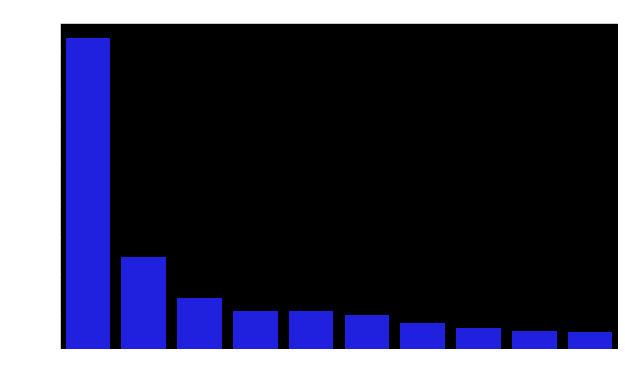

In [19]:
#Generate a plot that shows the Top 10 states in terms of Confirmed Covid cases by Laboratory test
covid_data = covid_data.sort_values(by='lab_confirmed_cases', ascending=False)
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(
    x=covid_data['States Affected'].head(10),
    y=covid_data['lab_confirmed_cases'].head(10),
    data=covid_data,
    ax=ax,
    color='blue'
    )
ax.set(
    xlabel = "States Affected",
    ylabel = "No. of Cases (Lab Confirmed)",
    title = "Top 10 States in terms of Lab Confirmed covid cases"
)

In [20]:
covid_data = covid_data.sort_values(by='discharged', ascending=False)

A plot that shows the Top 10 states in terms of Discharged covid cases

[Text(0.5, 0, 'States Affected'),
 Text(0, 0.5, 'Discharged Covid Cases'),
 Text(0.5, 1.0, 'Top 10 states in terms of discharged covid cases')]

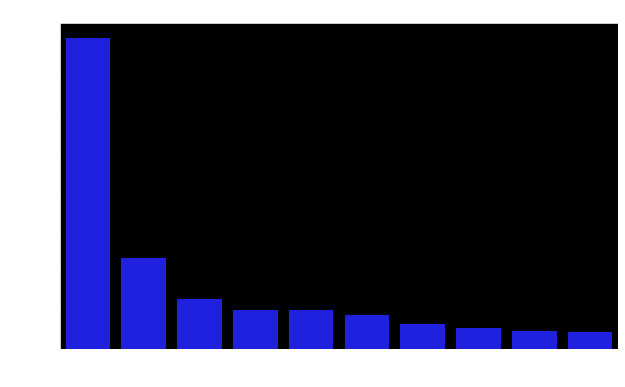

In [21]:
fig_dim = (10, 6)
fig, ax = plt.subplots(figsize=fig_dim)
sns.barplot(
    x=covid_data['States Affected'].head(10),
    y=covid_data['discharged'].head(10),
    ax=ax,
    data=covid_data,
    color='blue'
)
ax.set(
    xlabel = 'States Affected',
    ylabel = 'Discharged Covid Cases',
    title = "Top 10 states in terms of discharged covid cases"
)

In [22]:
covid_data = covid_data.sort_values(by='deaths', ascending=False)

Top 10 Death cases

[Text(0, 0.5, 'Deaths'), Text(0.5, 1.0, 'Top 10 Death Cases')]

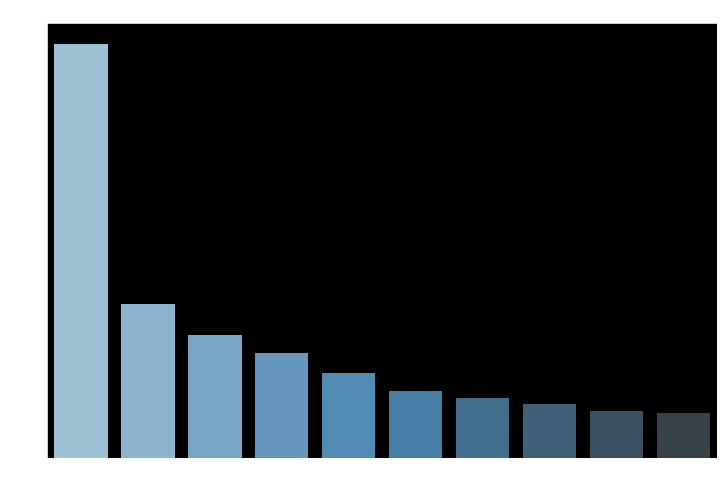

In [23]:
fig_dim = (12, 8)
fig, ax = plt.subplots(figsize=fig_dim)

sns.barplot(
    x=covid_data['States Affected'].head(10),
    y=covid_data['deaths'].head(10),
    ax=ax,
    data=covid_data,
    palette="Blues_d"
)

ax.set(
    ylabel="Deaths",
    title="Top 10 Death Cases"
)

Line Plot for total daily confirmed, recovered and death cases in Nigeria

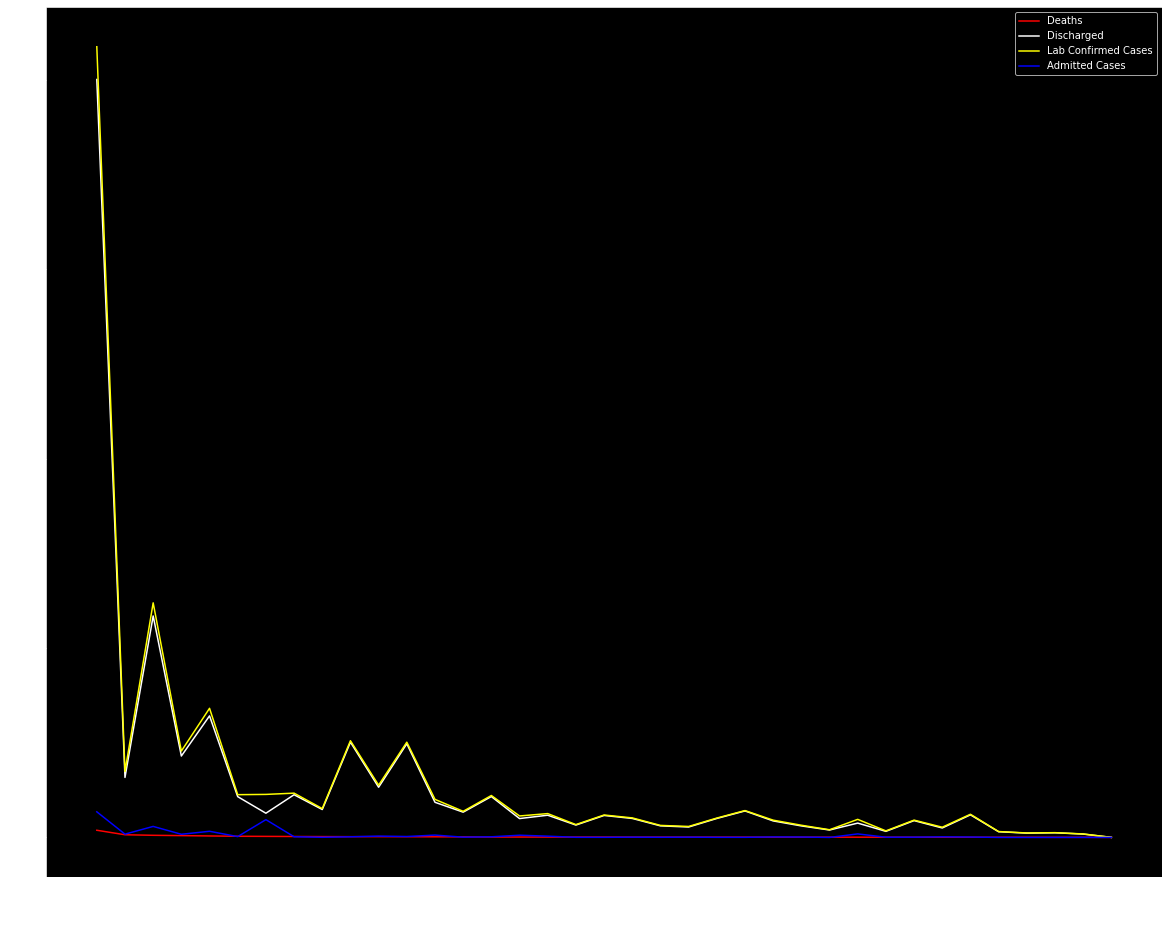

In [25]:
fig_dim = (20, 16)
fig, ax = plt.subplots(figsize=fig_dim)
x = covid_data['States Affected']

ax.plot(x, covid_data['deaths'], label='Deaths', color='red')
ax.plot(x, covid_data['discharged'], label='Discharged', color='white')
ax.plot(x, covid_data['lab_confirmed_cases'], label='Lab Confirmed Cases', color='yellow')
ax.plot(x, covid_data['admitted_cases'], label="Admitted Cases", color='blue')
ax.legend()
plt.xticks(rotation=45)
plt.show()


In [28]:
# Comparing the columns by calculating the difference between the rows

infection_rate = full_data[['Confirmed', 'recovered', 'deaths' ]].diff()
infection_rate

,Confirmed,recovered,deaths
0,NaN,NaN,NaN
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
194875,1068075.0,0.0,23838.0
194876,-1043379.0,0.0,-24248.0
194877,-455002.0,0.0,-2881.0
194878,204341.0,0.0,1700.0


In [41]:
full_data['infection_rate'] = full_data[['Confirmed']].diff().fillna(0)

In [52]:
full_data = full_data[full_data['Country/Region'] == 'Nigeria']

In [50]:
full_data.groupby('Date')['infection_rate'].sum()

Date
2020-01-22       0.0
2020-01-23       0.0
2020-01-24       0.0
2020-01-25       0.0
2020-01-26       0.0
               ...  
2021-12-13       0.0
2021-12-14    4872.0
2021-12-15    5678.0
2021-12-16    4367.0
2021-12-17    7510.0
Name: infection_rate, Length: 696, dtype: float64

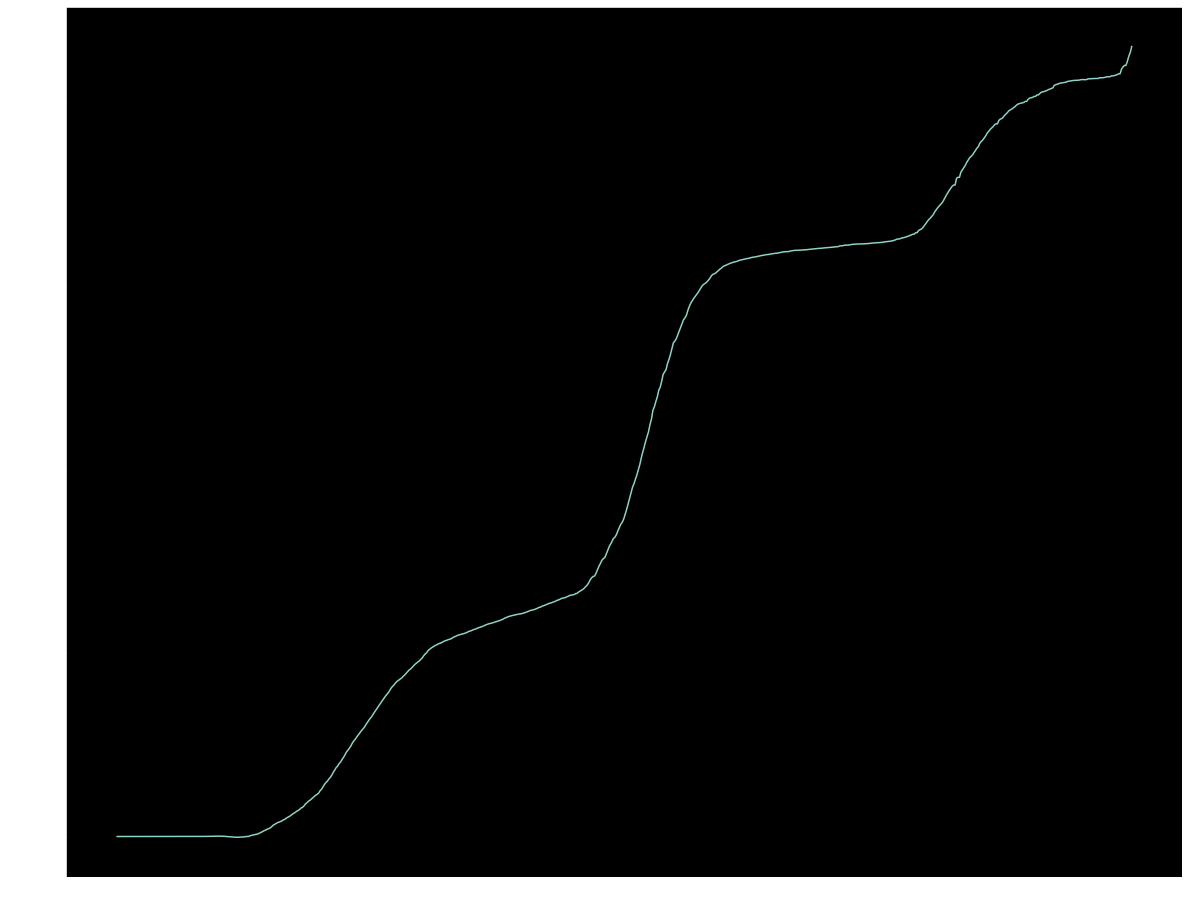

In [54]:
fig, ax = plt.subplots(figsize=fig_dim)
ax.plot(
    full_data['Date'], full_data['infection_rate'])

ax.set(
    ylabel="Infection Rate",
    xlabel="Date"
)

date_form = DateFormatter("%y-%m")
ax.xaxis.set_major_formatter(date_form)

In [62]:
full_data['Date'][full_data['infection_rate'] ==  max(full_data['infection_rate'])]

194802   2021-12-17
Name: Date, dtype: datetime64[ns]

In [64]:
covid_external.head()

,states,region,Population,Overall CCVI Index,Age,Epidemiological,Fragility,Health System,Population Density,Socio-Economic,Transport Availability,Acute IHR
0,FCT,North Central,4865000,0.3,0.0,0.9,0.4,0.6,0.9,0.6,0.2,0.79
1,Plateau,North Central,4766000,0.4,0.5,0.4,0.8,0.3,0.3,0.5,0.3,0.93
2,Kwara,North Central,3524000,0.3,0.4,0.3,0.2,0.4,0.2,0.6,0.7,0.93
3,Nassarawa,North Central,2783000,0.1,0.3,0.5,0.9,0.0,0.1,0.6,0.5,0.85
4,Niger,North Central,6260000,0.6,0.0,0.6,0.3,0.7,0.1,0.8,0.8,0.84


In [92]:
total_covid_data = pd.concat([covid_data, covid_external], join='outer', axis=1)

total_covid_data.to_csv('Total Covid Data.csv')

del total_covid_data['states']

In [93]:
covid_data.head()

,States Affected,lab_confirmed_cases,admitted_cases,discharged,deaths
0,Lagos,83514,2705,80053,756
1,FCT,24777,1162,23391,224
2,Rivers,13637,647,12836,154
3,Kaduna,10213,66,10066,81
4,Plateau,10061,95,9893,73


In [94]:
total_covid_data.head()

,States Affected,lab_confirmed_cases,admitted_cases,discharged,deaths,region,Population,Overall CCVI Index,Age,Epidemiological,Fragility,Health System,Population Density,Socio-Economic,Transport Availability,Acute IHR
0,Lagos,83514,2705,80053,756,North Central,4865000,0.3,0.0,0.9,0.4,0.6,0.9,0.6,0.2,0.79
1,FCT,24777,1162,23391,224,North Central,4766000,0.4,0.5,0.4,0.8,0.3,0.3,0.5,0.3,0.93
2,Rivers,13637,647,12836,154,North Central,3524000,0.3,0.4,0.3,0.2,0.4,0.2,0.6,0.7,0.93
3,Kaduna,10213,66,10066,81,North Central,2783000,0.1,0.3,0.5,0.9,0.0,0.1,0.6,0.5,0.85
4,Plateau,10061,95,9893,73,North Central,6260000,0.6,0.0,0.6,0.3,0.7,0.1,0.8,0.8,0.84


[Text(0, 0.5, 'Overall CCVI Index')]

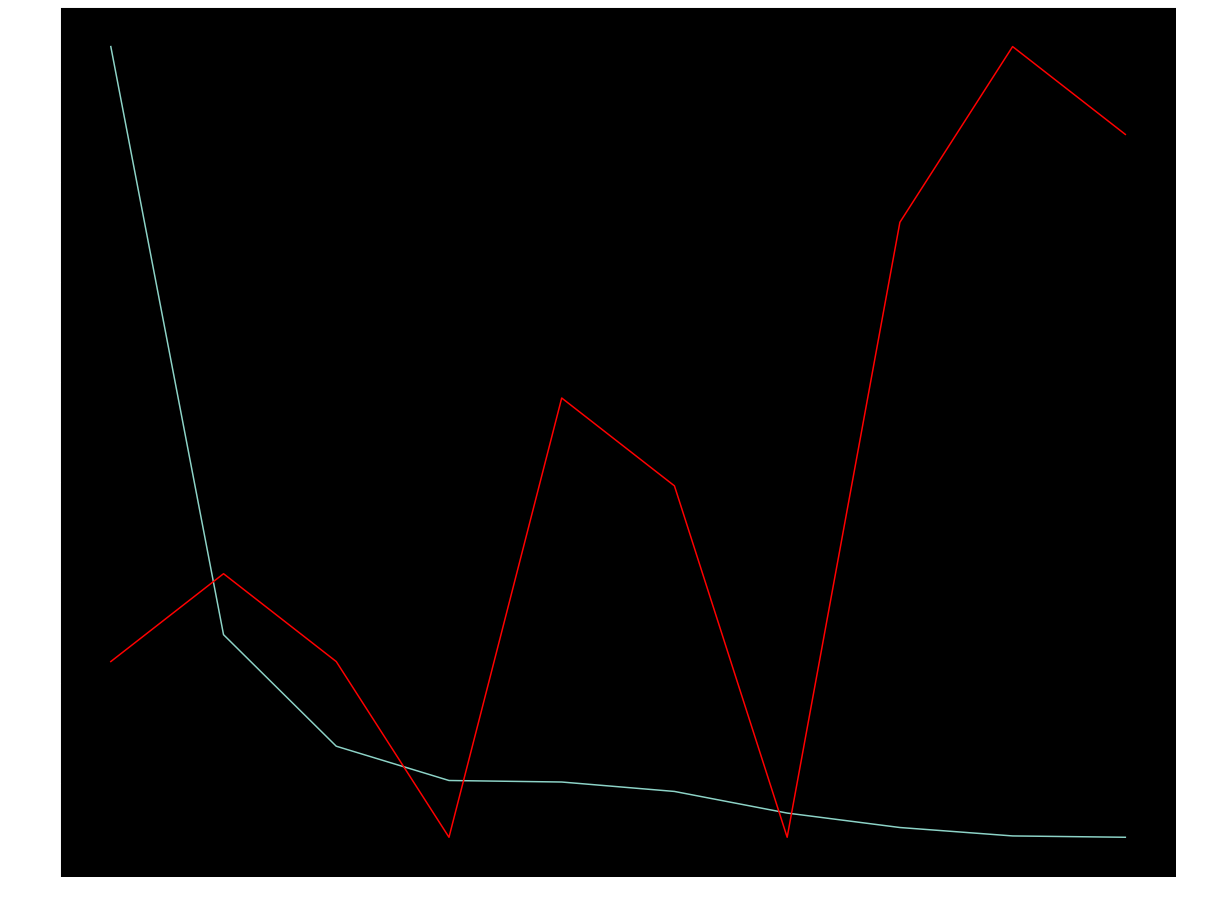

In [130]:
x = total_covid_data['States Affected']
y1 = total_covid_data[['States Affected' ,'lab_confirmed_cases', 'Overall CCVI Index']].nlargest(10, columns='lab_confirmed_cases')




fig = plt.figure(figsize=fig_dim)
ax1 = fig.add_subplot(111)
ax1.plot(
    y1['States Affected'],
    y1['lab_confirmed_cases']
)
ax1.set(
    ylabel="Lab Confirmed Cases",
    xlabel='States Affected',
)

ax2 = ax1.twinx()
ax2.plot(
    y1['States Affected'],
    y1['Overall CCVI Index'],
    color='red'
)
ax2.set(
    ylabel="Overall CCVI Index"
)


[Text(0.5, 0, 'Population Density'), Text(0, 0.5, 'Lab Confirmed Cases')]

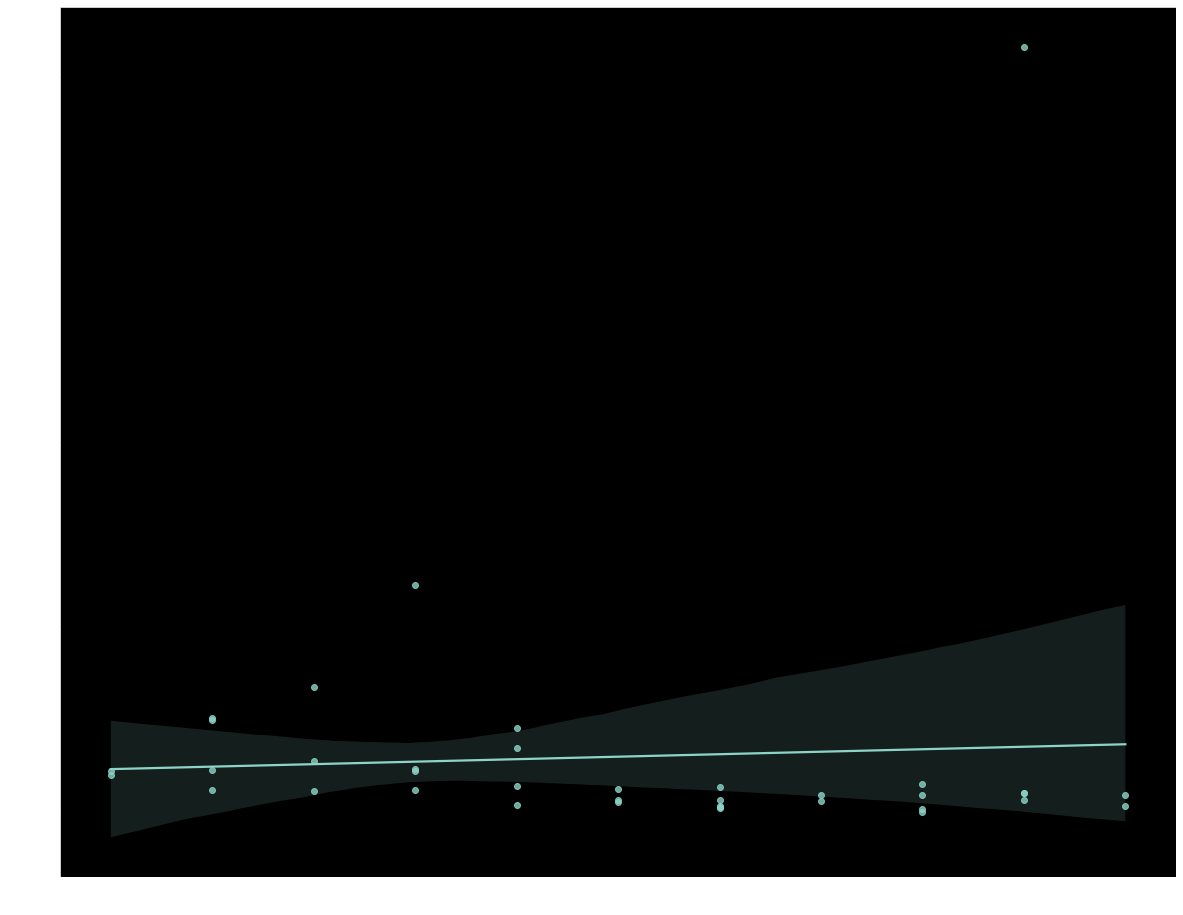

In [133]:
fig, ax = plt.subplots(figsize=fig_dim)
sns.regplot(
    x=total_covid_data['Population Density'],
    y=total_covid_data['lab_confirmed_cases']
)

ax.set(
    xlabel = 'Population Density',
    ylabel = 'Lab Confirmed Cases'
)

In [136]:
realGdp

,Year,Q1,Q2,Q3,Q4
0,2014,15438679.50,16084622.31,17479127.58,18150356.45
1,2015,16050601.38,16463341.91,17976234.59,18533752.07
2,2016,15943714.54,16218542.41,17555441.69,18213537.29
3,2017,15797965.83,16334719.27,17760228.17,18598067.07
4,2018,16096654.19,16580508.07,18081342.10,19041437.59
5,2019,16434552.65,16931434.89,18494114.17,19530000.00
6,2020,16740000.00,15890000.00,17820000.00,0.00


In [142]:
real_gdp = pd.melt(
    realGdp,
    id_vars='Year',
    var_name='Quarter',
    value_name="GDP")

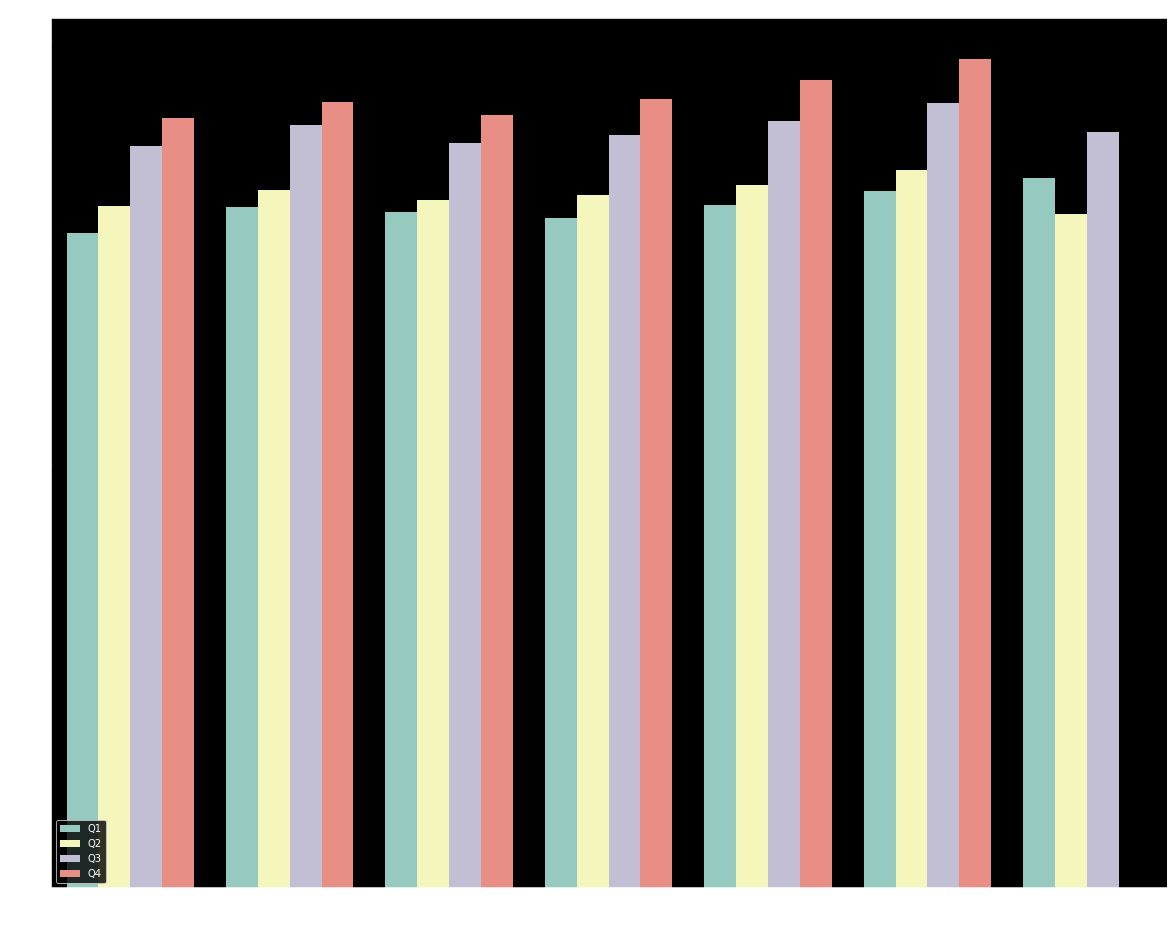

In [147]:
fig, ax = plt.subplots(figsize=fig_dim)

sns.barplot(
    x='Year',
    y='GDP',
    hue='Quarter',
    data = real_gdp,
    ax=ax
)
ax.axhline(6)
ax.legend(loc='lower left')